# Analisis de datos sobre consumo de sustancias psicoactivas

*import's* generales <br>Proyect hecho en Python 3.12.7

In [1]:
import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

Obtener los datos correspondientes

In [2]:
dconsum = pd.read_csv("drug_consumption.csv")
dconsum.drop("ID", axis = 1, inplace = True)
dconsum.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


Cuantificar categorias relacionadas al consumo de sustancias, dejando simplemente el digito
```Value	Description
CL0	Never Used
CL1	Used over a Decade Ago
CL2	Used in Last Decade
CL3	Used in Last Year
CL4	Used in Last Month
CL5	Used in Last Week
CL6	Used in Last Day```

In [3]:
quant_cat = {
    'CL0': 0,
    'CL1': 1,
    'CL2': 2,
    'CL3': 3,
    'CL4': 4,
    'CL5': 5,
    'CL6': 6,
}

dconsum.iloc[:,12:] = dconsum.iloc[:,12:].replace(quant_cat) 
dconsum.head()

,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,Cscore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,...,0,0,0,0,0,0,0,2,0,0
1,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,...,4,0,2,0,2,3,0,4,0,0
2,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,...,0,0,0,0,0,0,1,0,0,0
3,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,...,0,0,2,0,0,0,0,2,0,0
4,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,...,1,0,0,1,0,0,2,2,0,0


Obtenemos la columna realcionada con sustancias mas balanceada (tiene una cantidad similar de consumidores y no consumidores *CL0* )

In [4]:
def balanced_col(df, value):
    percentages = {} # Disctionary with percentages for each column
    
    #Precentage for each column
    for column in df.columns:
        count = df[column].eq(value).sum()
        total = len(df[column])
        precentage = (count/total) * 100
        percentages[column] = precentage #Store the result in the dictionary

    # Find the column with percentage closest to 50%
    closest_column = min(percentages, key=lambda x: abs(percentages[x] - 50))
    
    return percentages, closest_column

percentages, closest_column = balanced_col(dconsum.iloc[:,12:], 0)
print("La sustancia con mayor balance entre consumidores y no consumidores es " + closest_column)

La sustancia con mayor balance entre consumidores y no consumidores es Amphet


Convertimos `Amphet` en una columna que nos dice si consumio o nunca ha consumido

In [5]:
def clas_quant(value):
    if(value == 0):
        return 0
    return 1

dconsum["Amphet"] = dconsum["Amphet"].apply(clas_quant)

## Modelos para la clasificacion de consumidores de Anfetaminas

La premisa de nuestros modelos va a ser decidir si una persona es una potencial consumidora de anfetaminas en base a los datos proporcionados en `dconsum`, aplicando tambien un analisis estadistico.

Para esto usaremos los siguientes modelos estadisticos
- Regresion logistica
- KNN
- SVN
- Discriminante Lineal

Con las siguientes metricas de desempe;o
- F1-Score
- Recall
- Accuracy

Para esto es importante separar nuestras variables independientes y dependiente, ya que esto sera de utilidad en todos nuestros modelos

In [6]:
X = dconsum.iloc[:, dconsum.columns != 'Amphet']
X = X.apply(pd.to_numeric, errors='coerce')
y = dconsum["Amphet"]

### Modelo de regresion logistica

In [7]:
import statsmodels.api as sm

def clean_dataset(X, y, threshold=0.05):
    # Add a constant for the intercept term
    X = sm.add_constant(X)
    
    # Get the p-values
    model = sm.Logit(y, X).fit(disp=False)
    p_values = model.pvalues.drop('const')
    
    # Loop to remove variables with p-values greater than the threshold
    while p_values.max() > threshold:
        to_drop = p_values.idxmax() #Drop the variable with the highest p-value
        
        print(f"\nRemoving variable: {to_drop} with p-value: {p_values.max()}")
        
        # Remove the variable from the dataset
        X = X.drop(columns=[to_drop])
        
        # Get the updated p-values
        model = sm.Logit(y, X).fit(disp=False)
        p_values = model.pvalues.drop('const')
    
    return X

X_reduc = clean_dataset(X, y)



Removing variable: Ketamine with p-value: 0.9624978842015393

Removing variable: Mushrooms with p-value: 0.8488077845726859

Removing variable: Choc with p-value: 0.7278496368496175

Removing variable: Cscore with p-value: 0.7063567031792226

Removing variable: Ethnicity with p-value: 0.6177658196423583

Removing variable: Country with p-value: 0.5915959757842191

Removing variable: Legalh with p-value: 0.5059085488451447

Removing variable: Semer with p-value: 0.29216048498571057

Removing variable: Caff with p-value: 0.2629005672418927

Removing variable: Oscore with p-value: 0.251051317634981

Removing variable: Nscore with p-value: 0.28973608892048663

Removing variable: Impulsive with p-value: 0.1915516280687628

Removing variable: Crack with p-value: 0.14143273238454232

Removing variable: Education with p-value: 0.13438574325928757

Removing variable: Gender with p-value: 0.16494458222569874

Removing variable: Ascore with p-value: 0.18102545094719902

Removing variable: VSA wi

A su vez dividimos los datasets en entrenamiento y pruebas, con una relacion 80-20

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=45)

Definimos una función para que reciba un random state y retorne las metricas más importantes del modelo creado

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def acc_logistic_regression(random_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    # Crear el modelo de regresión logística
    model = LogisticRegression(max_iter=1000)  # Aumenta las iteraciones si es necesario

    # Entrenar el modelo
    model.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = model.predict(X_test)

    # Obtener las métricas como diccionario
    report = classification_report(y_test,y_pred,output_dict=True)
    
    #Retornar las metricas importantes
    return report['accuracy'], report['weighted avg']['precision'], report['weighted avg']['recall'], report['weighted avg']['f1-score']
    

Usamos la función creada anteriormente con 100 valores de random state

In [10]:
import numpy as np

random_states = np.arange(1,101) #100 Valores de random state 1...100
accuracies = []
precisions = []
recalls = []
f1_scores = []
averages = []

# Evaluar el modelo con cada random_state
for state in random_states:
    accuracy, precision, recall, f1 = acc_logistic_regression(state)
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    averages.append((precision + recall + f1) / 3)

Convertimos los resultados obtenidos en un DataFrame para su posterior análisis

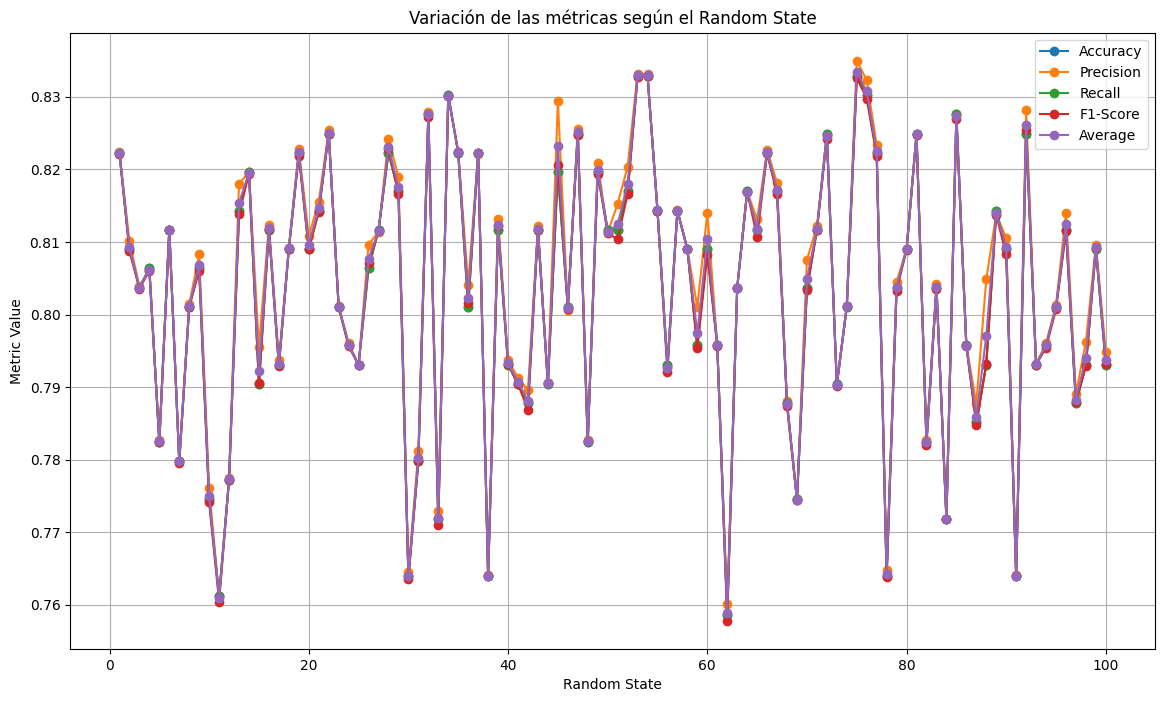

In [11]:
import matplotlib.pyplot as plt

results_df = pd.DataFrame({
    'random_state': random_states,
    'accuracy': accuracies,
    'precision': precisions,
    'recall': recalls,
    'f1_score': f1_scores,
    'average' : averages
})

# Graficar las métricas
plt.figure(figsize=(14, 8))
plt.plot(random_states, accuracies, label='Accuracy', marker='o')
plt.plot(random_states, precisions, label='Precision', marker='o')
plt.plot(random_states, recalls, label='Recall', marker='o')
plt.plot(random_states, f1_scores, label='F1-Score', marker='o')
plt.plot(random_states, averages, label='Average', marker='o')
plt.xlabel('Random State')
plt.ylabel('Metric Value')
plt.title('Variación de las métricas según el Random State')
plt.legend()
plt.grid(True)
plt.show()

Ahora extraemos el random state con el mayor promedio del DataFrame anterior.

In [18]:
best_random_state = results_df['average'].idxmax() + 1
print(f"El mejor random_state es {best_random_state} con un promedio de {results_df['average'].max()}")

El mejor random_state es 75 con un promedio de 0.8334926153967639



Ahora, creamos un modelo con el random state obtenido y extraemos sus metricas

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=best_random_state)
# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)  # Aumenta las iteraciones si es necesario

# Entrenar el modelo
model.fit(X_train, y_train)

# Hacer predicciones
y_pred = model.predict(X_test)

# Obtener las métricas como diccionario
report = classification_report(y_test,y_pred,output_dict=True)


Por último mostramos la matriz de confusión.

In [22]:
print(confusion_matrix(y_test, y_pred))

[[165  24]
 [ 39 149]]


### Modelo de KNN

In [20]:
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

def drop_least_important_features(X, y, n_neighbors=5, threshold=0.01):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    while True:
        # Dividir los datos y entrenar el modelo
        knn.fit(X, y)
        
        # Calcular importancia de las características mediante permutación
        result = permutation_importance(knn, X, y, n_repeats=10, random_state=42, n_jobs=-1)
        
        # Obtener la importancia mínima
        min_importance = result.importances_mean.min()
        
        # Si la importancia más baja es mayor que el umbral, detenemos
        if min_importance > threshold:
            break
        
        # Identificar y eliminar la característica menos importante
        least_important_feature = X.columns[result.importances_mean.argmin()]
        X = X.drop(columns=[least_important_feature])
        print(f'Eliminando característica: {least_important_feature}')
    
    return X

# Aplicar la función para eliminar características menos importantes
X_reduced = drop_least_important_features(X, y)

Eliminando característica: Oscore
Eliminando característica: Nscore
Eliminando característica: Ketamine
Eliminando característica: Education
Eliminando característica: Country
Eliminando característica: Semer
Eliminando característica: Ethnicity
Eliminando característica: Crack
Eliminando característica: Gender
Eliminando característica: Heroin
Eliminando característica: VSA
Eliminando característica: Ascore
Eliminando característica: Impulsive
Eliminando característica: SS
Eliminando característica: Alcohol
Eliminando característica: Caff
Eliminando característica: Escore
Eliminando característica: Age
Eliminando característica: Cscore
Eliminando característica: Choc


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=45)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def find_best_k(X_train, X_test, y_train, y_test, k_range=range(1, 40), cv=2):
    # Define the KNN model
    knn = KNeighborsClassifier()

    # Define the values of k to evaluate
    param_grid = {'n_neighbors': list(k_range)}

    # Use GridSearchCV to test the values of k
    grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy')

    # Fit the model to the training data
    grid_search.fit(X_train, y_train)

    # Get the best value of k
    best_k = grid_search.best_params_['n_neighbors']

    # Evaluate the model with the best number of neighbors
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test)

    # Print the accuracy of the model
    accuracy = accuracy_score(y_test, y_pred)

    return best_k, accuracy


best_k, best_accuracy = find_best_k(X_train, X_test, y_train, y_test)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print(f'Best k: {best_k} ')
y_pred = knn.predict(X_test)
a2 = accuracy_score(y_test, knn.predict(X_test))


Best k: 19 


Metricas de desempe;o

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.71      0.81       217
           1       0.70      0.92      0.80       160

    accuracy                           0.80       377
   macro avg       0.81      0.82      0.80       377
weighted avg       0.83      0.80      0.80       377



Matriz de confusion

In [ ]:
m2 = confusion_matrix(y_test, y_pred)

### Modelo de SVM

In [ ]:
X_reduc = clean_dataset(X, y)


Removing variable: Ketamine with p-value: 0.9624978842015395

Removing variable: Mushrooms with p-value: 0.8488077845726834

Removing variable: Choc with p-value: 0.7278496368496228

Removing variable: Cscore with p-value: 0.706356703179222

Removing variable: Ethnicity with p-value: 0.6177658196423559

Removing variable: Country with p-value: 0.5915959757842223

Removing variable: Legalh with p-value: 0.5059085488451457

Removing variable: Semer with p-value: 0.29216048498571057

Removing variable: Caff with p-value: 0.2629005672418857

Removing variable: Oscore with p-value: 0.2510513176349809

Removing variable: Nscore with p-value: 0.28973608892048563

Removing variable: Impulsive with p-value: 0.19155162806876314

Removing variable: Crack with p-value: 0.14143273238454224

Removing variable: Education with p-value: 0.13438574325928687

Removing variable: Gender with p-value: 0.16494458222569852

Removing variable: Ascore with p-value: 0.18102545094719913

Removing variable: VSA w

In [ ]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduc, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.svm import SVC    
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM model
svm_model = SVC(kernel='linear', C=1)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
a3 = accuracy_score(y_test, y_pred)

Metricas de desempe;o

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       196
           1       0.84      0.73      0.78       181

    accuracy                           0.80       377
   macro avg       0.81      0.80      0.80       377
weighted avg       0.81      0.80      0.80       377



Matriz de confusion

In [ ]:
m3 = confusion_matrix(y_test, y_pred)

### Modelo de discriminante lineal

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_reduc, y, test_size=0.2, random_state=42)

# Crear el modelo de análisis discriminante lineal
lda = LinearDiscriminantAnalysis()

# Entrenar el modelo
lda.fit(X_train, y_train)

# Hacer predicciones
y_pred = lda.predict(X_test)

# Calcular la precisión
a4 = accuracy_score(y_test, y_pred)

Metricas de desempe;o

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.84      0.80       196
           1       0.81      0.72      0.76       181

    accuracy                           0.79       377
   macro avg       0.79      0.78      0.78       377
weighted avg       0.79      0.79      0.78       377



Matriz de confusion

In [ ]:
m4 = confusion_matrix(y_test, y_pred)

In [ ]:
m1, m2, m3, m4

(array([[170,  47],
        [ 21, 139]]),
 array([[155,  62],
        [ 13, 147]]),
 array([[170,  26],
        [ 48, 133]]),
 array([[165,  31],
        [ 50, 131]]))

In [ ]:
a1,a2,a3,a4

(0.8196286472148541,
 0.8010610079575596,
 0.8037135278514589,
 0.7851458885941645)